In [1]:
# list of all data files


# loop over each fish
    # extract neural activity (subset of ROIs)
    # average this neural activity
    # create stim_on mask
    # plot a figure with these overlaid

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

Full neural dataset shape is: (43350, 93122)
Truncated dataset size: (43350, 10000)
Attempting to parse stim: left_spot
Label shape: (43350,)
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Label shape: (43350,)
Stim type right_spot parsed successfully.
Full neural dataset shape is: (38550, 101435)
Truncated dataset size: (38550, 10000)
Attempting to parse stim: left_spot
Label shape: (38550,)
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Label shape: (38550,)
Stim type right_spot parsed successfully.
Full neural dataset shape is: (44250, 104479)
Truncated dataset size: (44250, 10000)
Attempting to parse stim: left_spot
Label shape: (44250,)
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Label shape: (44250,)
Stim type right_spot parsed successfully.
Full neural dataset shape is: (42900, 93711)
Truncated dataset size: (42900, 10000)
Attempting to parse stim: left_spot
Label shape: (42900,)
Stim

ValueError: not enough values to unpack (expected 4, got 2)

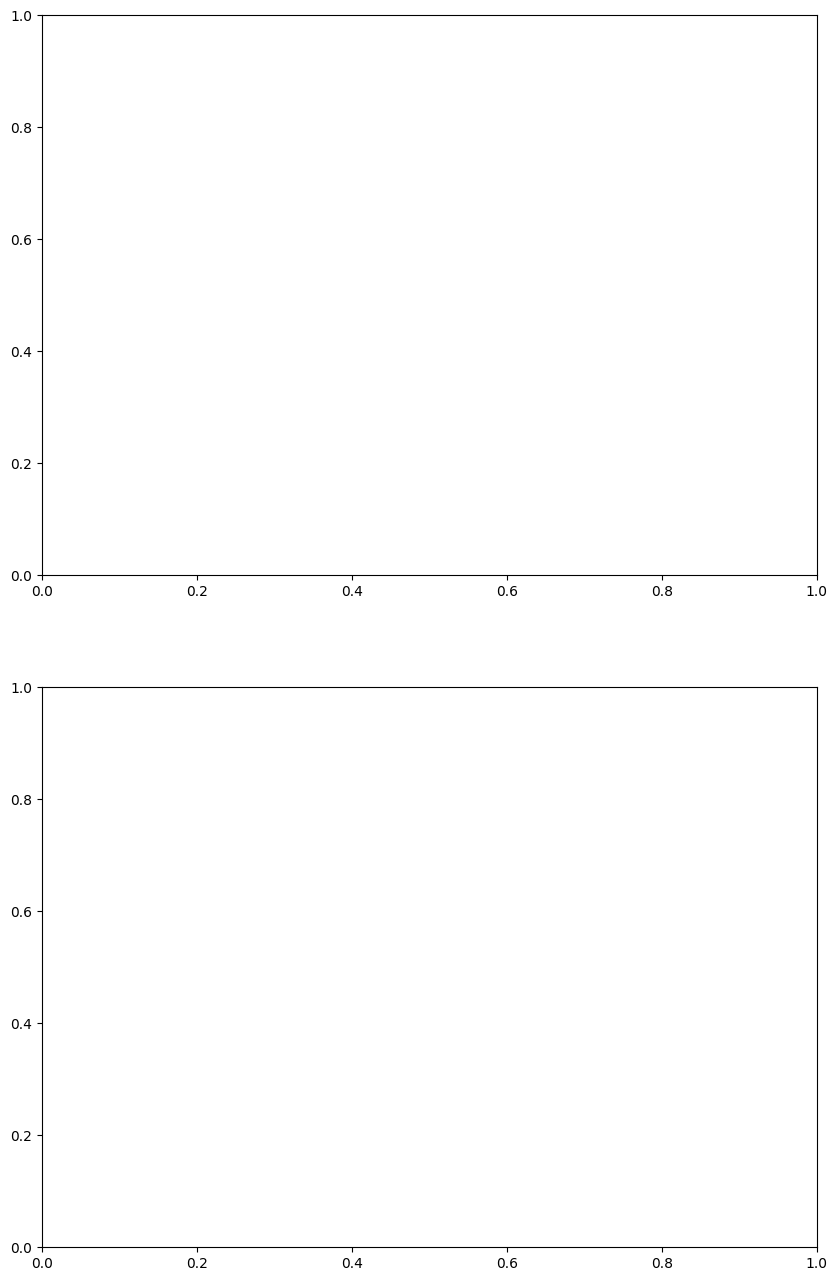

In [31]:
### Produce plots of mean neural acitivty overlaid with 

## list all data files ##

dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

filenames =  [data.split('/')[-1][:-3] for filepath in dat_files] # fish and date only


rois = 10000
stim_types = {'left_spot':0, 'right_spot':1,  \
              'open_loop_grating':2, 'closed_loop_grating':3}
stims = ['left_spot', 'right_spot']


neural_list, stim_on_list = [], []
for i in range(len(dat_files)):
    data = dat_files[i]


    ## extract neural activity (subset of rois) ##

    with h5py.File(data, 'r') as f:

        # get calcium signal
        neural = f['rois']['dfof']
        print(f"Full neural dataset shape is: {neural.shape}")

        # subset neural by selecting all timesteps and random  "rois" rois
        neural_indexes = np.sort(
                            np.random.choice(
                                        np.arange(neural.shape[1]), size=rois, replace=False
                                        )
                            )

        neural = np.array(neural[:, neural_indexes])
        print(f"Truncated dataset size: {neural.shape}")
        assert(neural.shape == (neural.shape[0], rois))

        ## average this neural actibity across rois ##

        neural_mean = np.mean(neural, axis=1)

        ## create stim_on mask ##

        # get stimulus presentations
        stimuli = f['visuomotor']['presentations']
        stim_type = stimuli['stim_type'].astype(int)
        stim_on_fr = stimuli['onset_frame'].astype(int)
        stim_end_fr = stimuli['offset_frame'].astype(int)

        # initialise lists for the chosen stimuli
        (stim_pres_idx_list, stim_on_fr_list,
        stim_end_fr_list, stim_on_mask_list)  = [],[],[],[]


        # loop through chosen stimuli and find boolean masks for their 'on' frames
        for stim in stims:

            # convert stim name to stim number
            stim_num = stim_types[stim] 
            print(f'Attempting to parse stim: {stim}') 

            # find the presentation indexes for the specified stim type
            # must account for data index starting at 1
            this_stim_pres_indexes = np.where(np.isin(stim_type, stim_num + 1))[0]
            stim_pres_idx_list.append(this_stim_pres_indexes)

            # index stim onset frame numbers with the presentation indexes
            this_stim_on_frames = stim_on_fr[this_stim_pres_indexes]
            # this_stim_on_frames = this_stim_on_frames[this_stim_on_frames]
            stim_on_fr_list.append(this_stim_on_frames)

            # index stim end frame numbers with the presentation indexes
            this_stim_end_frames = stim_end_fr[this_stim_pres_indexes]
            # this_stim_end_frames = this_stim_end_frames[this_stim_end_frames]
            stim_end_fr_list.append(this_stim_end_frames)

            # create a boolean mask of stimulus presentation frames (1 == stimulus on, 0 == stimulus off)
            this_stim_on_mask = np.zeros(neural.shape[0]).astype(int)
            this_stim_on_mask[[this_stim_on_frames, this_stim_end_frames]] = 1
            # perform bitwise XOR operation on consecutive elements of stim_on_mask. This will convert all 
            # but stim_off frame to 1s. Combining with "OR stim_on_mask" will also include the stim_off frame
            this_stim_on_mask = np.bitwise_xor.accumulate(this_stim_on_mask) | this_stim_on_mask
            stim_on_mask_list.append(this_stim_on_mask)

            # assert shapes
            print(f"Label shape: {stim_on_mask_list[0].shape}")
            assert(stim_on_mask_list[0].size == neural.shape[0])

            print(f'Stim type {stim} parsed successfully.')

        # append each fish to a list
        stim_on_list.append([stim_pres_idx_list, stim_on_fr_list, stim_end_fr_list, stim_on_mask_list])
        neural_list.append(neural_mean)

## plot figures with overlaid mean activity and stim_on mask for each fish ## 

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,16))
axes = (ax1, ax2, ax3, ax4)

# figure for each fish
for i in range(len(axes)):
    # plot average neural data (first n timesteps)
    axes[i].plot(neural_list[i][:7500], label='mean neural activity')
    # plot stimulus on mask for spots (first n timesteps)
    axes[i].plot(stim_on_list[i][-1][0][:7500], alpha=0.5, label='left spot')
    axes[i].plot(stim_on_list[i][-1][1][:7500], alpha=0.5, label='right spot')

    axes[i].set_title(f"{filenames[i]}")
    axes[i].legend(fontsize='x-small', loc='upper right')

plt.show()

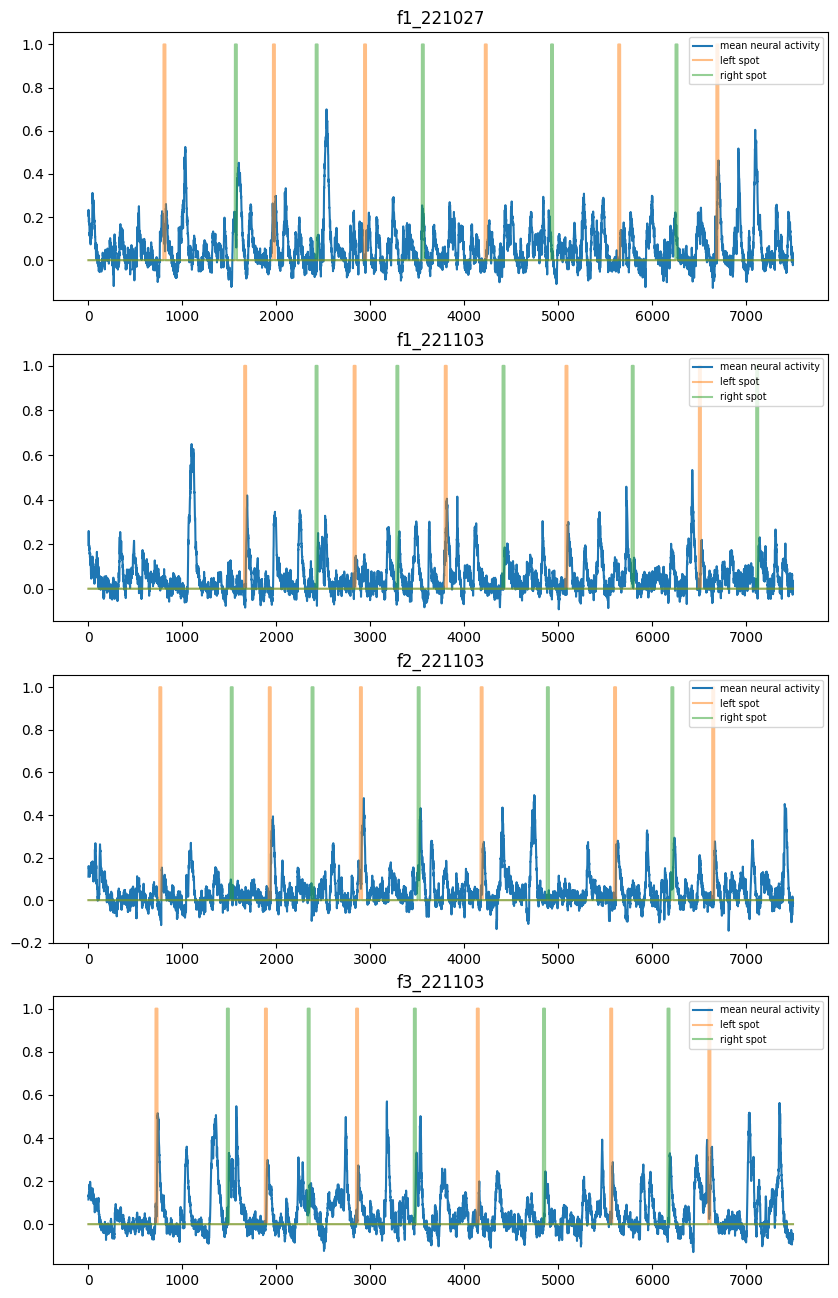

In [49]:
filenames =  [filepath.split('/')[-1][:-3] for filepath in dat_files] # fish and date only


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,16))
axes = (ax1, ax2, ax3, ax4)

# figure for each fish
for i in range(len(axes)):
    # plot average neural data (first n timesteps)
    axes[i].plot(neural_list[i][:7500], label='mean neural activity')
    # plot stimulus on mask for spots (first n timesteps)
    axes[i].plot(stim_on_list[i][-1][0][:7500], alpha=0.5, label='left spot')
    axes[i].plot(stim_on_list[i][-1][1][:7500], alpha=0.5, label='right spot')

    axes[i].set_title(f"{filenames[i]}")
    axes[i].legend(fontsize='x-small', loc='upper right')

plt.show()